In [ ]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar

--2023-05-24 16:56:31--  http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460032000 (439M) [application/x-tar]
Saving to: ‘VOCtrainval_06-Nov-2007.tar’

VOCtrainval_06-Nov- 100%[===================>] 438.72M  26.1MB/s    in 17s     

2023-05-24 16:56:48 (26.3 MB/s) - ‘VOCtrainval_06-Nov-2007.tar’ saved [460032000/460032000]



In [ ]:
!tar -xvf /content/VOCtrainval_06-Nov-2007.tar

In [ ]:
!pip install keras-retinanet

In [ ]:
from keras_retinanet.preprocessing import *

In [ ]:
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET


def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            bbx = member.find('bndbox')
            xmin = int(bbx.find('xmin').text)
            ymin = int(bbx.find('ymin').text)
            xmax = int(bbx.find('xmax').text)
            ymax = int(bbx.find('ymax').text)
            label = member.find('name').text

            value = ('/content/VOCdevkit/VOC2007/JPEGImages/'+root.find('filename').text,

                     xmin,
                     ymin,
                     xmax,
                     ymax,label
                     )
            xml_list.append(value)
    column_name = ['filename', 'xmin', 'ymin', 'xmax', 'ymax','class']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df


def main():
    image_path = '/content/VOCdevkit/VOC2007/Annotations'
    xml_df = xml_to_csv(image_path)
    xml_df.to_csv('labels.csv', index=None)
    print('Successfully converted xml to csv.')


main()

Successfully converted xml to csv.


In [ ]:
!git clone https://github.com/martinzlocha/anchor-optimization.git

Cloning into 'anchor-optimization'...
remote: Enumerating objects: 77, done.
remote: Total 77 (delta 0), reused 0 (delta 0), pack-reused 77
Unpacking objects: 100% (77/77), 33.70 KiB | 884.00 KiB/s, done.


In [ ]:
%cd /content/anchor-optimization

/content/anchor-optimization


In [ ]:
!pip install  .

In [ ]:
!python setup.py build_ext --inplace

/usr/local/lib/python3.10/dist-packages/setuptools/__init__.py:84: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
!!

        ********************************************************************************
        Requirements should be satisfied by a PEP 517 installer.
        If you are using pip, you can try `pip install --use-pep517`.
        ********************************************************************************

!!
  dist.fetch_build_eggs(dist.setup_requires)
running build_ext
skipping 'anchor_optimization/utils/compute_overlap.c' Cython extension (up-to-date)
copying build/lib.linux-x86_64-cpython-310/anchor_optimization/utils/compute_overlap.cpython-310-x86_64-linux-gnu.so -> anchor_optimization/utils


In [ ]:
%%writefile /content/anchor-optimization/anchor_optimization/optimize_anchors.py


import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
import csv
import os
import sys
sys.path.append('/content/anchor-optimization/anchor_optimization')
import numpy as np
import scipy.optimize
from PIL import Image
from utils.compute_overlap import compute_overlap
from keras_retinanet.preprocessing.csv_generator import _open_for_csv
from keras_retinanet.utils.anchors import generate_anchors, AnchorParameters, anchors_for_shape
from keras_retinanet.utils.image import compute_resize_scale
from keras_cv import layers as cv_layers

# global variable
global state
state = {'best_result': sys.maxsize}


def calculate_config(values,
                     ratio_count,
                     SIZES=[32, 64, 128, 256, 512],
                     STRIDES=[8, 16, 32, 64, 128]):

    split_point = int((ratio_count - 1) / 2)

    ratios = [1]
    for i in range(split_point):
        ratios.append(values[i])
        ratios.append(1 / values[i])

    scales = values[split_point:]

    return (SIZES, STRIDES, ratios, scales)


def base_anchors_for_shape(pyramid_levels=None,
                           anchor_params=None):

    if pyramid_levels is None:
        pyramid_levels = [3, 4, 5, 6, 7]

    if anchor_params is None:
        anchor_params = {strides : [8, 16, 32],
    scales: [1, 1.2599210498948732, 1.5874010519681994],
    sizes : [32.0, 64.0, 128.0],
    aspect_ratios : [0.5, 1.0, 2.0]}

    # compute anchors over all pyramid levels
    all_anchors = np.zeros((0, 4))
    for idx, p in enumerate(pyramid_levels):
        anchors = cv_layers.AnchorGenerator(
            bounding_box_format = 'xyxy'
            anchor_sizes=anchor_params.sizes[idx],
            aspect_ratios=anchor_params.ratios,
            scales=anchor_params.scales,
            strides = anchor_params.strides
        )
        all_anchors = np.append(all_anchors, anchors, axis=0)

    return all_anchors


def average_overlap(values,
                    entries,
                    image_shape,
                    mode='focal',
                    ratio_count=3,
                    include_stride=False,
                    SIZES=[32, 64, 128, 256, 512],
                    STRIDES=[8, 16, 32, 64, 128],
                    verbose=False,
                    set_state=None,
                    to_tuple=False,
                    threads=1):

    anchor_params = calculate_config(values,
                                     ratio_count,
                                     SIZES,
                                     STRIDES)
    if include_stride:
        anchors = anchors_for_shape(image_shape, anchor_params=anchor_params)
    else:
        anchors = base_anchors_for_shape(anchor_params=anchor_params)

    overlap = compute_overlap(entries, anchors)
    max_overlap = np.amax(overlap, axis=1)
    not_matched = len(np.where(max_overlap < 0.5)[0])

    if mode == 'avg':
        result = 1 - np.average(max_overlap)
    elif mode == 'ce':
        result = np.average(-np.log(max_overlap))
    elif mode == 'focal':
        result = np.average(-(1 - max_overlap) ** 2 * np.log(max_overlap))
    else:
        raise Exception('Invalid mode.')

    if set_state is not None:
        state = set_state

    # --------------------------------------------------------------------------------------------------------------------------------
    # "scipy.optimize.differential_evolution" utilizes multiprocessing but internally uses "multiprocessing.Pool" and not
    # "multiprocessing.Process" which is required for sharing state between processes
    # (see: https://docs.python.org/3/library/multiprocessing.html#sharing-state-between-processes)
    #
    # the "state" variable does not affect directly the "scipy.optimize.differential_evolution" process, therefore updates will be
    # printed out in case of improvement only if a single thread is used
    # --------------------------------------------------------------------------------------------------------------------------------

    if threads == 1:

        if result < state['best_result']:
            state['best_result'] = result

            if verbose:
                print('Current best anchor configuration')
                print('State: {}'.format(np.round(state['best_result'], 5)))
                print(
                    'Ratios: {}'.format(
                        sorted(
                            np.round(
                                anchor_params.ratios,
                                3))))
                print(
                    'Scales: {}'.format(
                        sorted(
                            np.round(
                                anchor_params.scales,
                                3))))

            if include_stride:
                if verbose:
                    print(
                        'Average overlap: {}'.format(
                            np.round(
                                np.average(max_overlap),
                                3)))

            if verbose:
                print(
                    "Number of labels that don't have any matching anchor: {}".format(not_matched))
                print()

    if to_tuple:
        # return a tuple, which happens in the last call to the 'average_overlap' function
        return result, not_matched
    else:
        return result



def anchors_optimize(annotations,
                     ratios=3,
                     scales=3,
                     objective='focal',
                     popsize=15,
                     mutation=0.5,
                     image_min_side=800,
                     image_max_side=1333,
                     # default SIZES values
                     SIZES=[32, 64, 128, 256, 512],
                     # default STRIDES values
                     STRIDES=[8, 16, 32, 64, 128],
                     include_stride=False,
                     resize=False,
                     threads=1,
                     verbose=False,
                     seed=None):

    """
    Important Note: The python "anchors_optimize" function is meant to be used from the command line (from within a Python console it gives incorrect results)
    """

    if ratios % 2 != 1:
        raise Exception('The number of ratios has to be odd.')

    entries = np.zeros((0, 4))
    max_x = 0
    max_y = 0

    updating = 'immediate'
    if threads > 1:
        # when the number of threads is > 1 then 'updating' is set to 'deferred' by default (see the documentation of "scipy.optimize.differential_evolution())
        updating = 'deferred'

    if seed is None:
        seed = np.random.RandomState()
    else:
        seed = np.random.RandomState(seed)

    if verbose:
        print('Loading object dimensions.')

    with _open_for_csv(annotations) as file:
        next(file)
        for line, row in enumerate(csv.reader(file, delimiter=',')):
            x1, y1, x2, y2 = list(map(lambda x: int(x), row[1:5]))

            if not x1 or not y1 or not x2 or not y2:
                continue

            if resize:
                # Concat base path from annotations file follow retinanet
                base_dir = os.path.split(annotations)[0]
                relative_path = row[0]
                image_path = os.path.join(base_dir, relative_path)
                img = Image.open(image_path)

                if hasattr(img, "shape"):
                    image_shape = img.shape
                else:
                    image_shape = (img.size[0], img.size[1], 3)

                scale = compute_resize_scale(
                    image_shape, min_side=image_min_side, max_side=image_max_side)
                x1, y1, x2, y2 = list(map(lambda x: int(x) * scale, row[1:5]))

            max_x = max(x2, max_x)
            max_y = max(y2, max_y)

            if include_stride:
                entry = np.expand_dims(np.array([x1, y1, x2, y2]), axis=0)
                entries = np.append(entries, entry, axis=0)
            else:
                width = x2 - x1
                height = y2 - y1
                entry = np.expand_dims(
                    np.array([-width / 2, -height / 2, width / 2, height / 2]), axis=0)
                entries = np.append(entries, entry, axis=0)

    image_shape = [max_y, max_x]

    if verbose:
        print('Optimising anchors.')

    bounds = []

    for i in range(int((ratios - 1) / 2)):
        bounds.append((1, 4))

    for i in range(scales):
        bounds.append((0.4, 2))

    update_state = None
    if threads == 1:
        update_state = state

    ARGS = (entries,
            image_shape,
            objective,
            ratios,
            include_stride,
            SIZES,
            STRIDES,
            verbose,
            update_state,
            # return a single value ('to_tuple' parameter is set to False)
            False,
            threads)

    result = scipy.optimize.differential_evolution(func=average_overlap,
                                                   # pass the '*args' as a tuple (see: https://stackoverflow.com/q/32302654)
                                                   args=ARGS,
                                                   mutation=mutation,
                                                   updating=updating,
                                                   workers=threads,
                                                   bounds=bounds,
                                                   popsize=popsize,
                                                   seed=seed)

    if hasattr(result, 'success') and result.success:
        print('Optimization ended successfully!')
    elif not hasattr(result, 'success'):
        print('Optimization ended!')
    else:
        print('Optimization ended unsuccessfully!')
        print('Reason: {}'.format(result.message))

    values = result.x
    anchor_params = calculate_config(values,
                                     ratios,
                                     SIZES,
                                     STRIDES)

    (avg, not_matched) = average_overlap(values,
                                         entries,
                                         image_shape,
                                         'avg',
                                         ratios,
                                         include_stride,
                                         SIZES,
                                         STRIDES,
                                         verbose,
                                         # pass a specific value to the 'set_state' parameter
                                         {'best_result': 0},
                                         # return a 'tuple'  ('to_tuple' parameter is set to True)
                                         True,
                                         # set the 'threads' parameter to 1
                                         1)

    # as 'end_state' set the 'avg' value
    end_state = np.round(avg, 5)
    RATIOS_result = sorted(np.round(anchor_params.ratios, 3))
    SCALES_result = sorted(np.round(anchor_params.scales, 3))

    print()
    print('Final best anchor configuration')
    print('State: {}'.format(end_state))
    print('Ratios: {}'.format(RATIOS_result))
    print('Scales: {}'.format(SCALES_result))

    dict_out = {
        'ratios': RATIOS_result,
        'scales': SCALES_result,
        'not_matched': not_matched,
        'end_state': end_state}

    if include_stride:
        STRIDE = np.round(1 - avg, 3)
        print('Average overlap: {}'.format(STRIDE))
        dict_out['stride'] = STRIDE

    print("Number of labels that don't have any matching anchor: {}".format(not_matched))

    return dict_out


In [ ]:
%%writefile /content/anchor-optimization/anchor_optimization/optimize_anchors.py


import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
import csv
import os
import sys
sys.path.append('/content/anchor-optimization/anchor_optimization')
import numpy as np
import scipy.optimize
from PIL import Image
from utils.compute_overlap import compute_overlap
from keras_retinanet.preprocessing.csv_generator import _open_for_csv
from keras_retinanet.utils.anchors import generate_anchors, AnchorParameters, anchors_for_shape
from keras_retinanet.utils.image import compute_resize_scale


# global variable
global state
state = {'best_result': sys.maxsize}


def calculate_config(values,
                     ratio_count,
                     SIZES=[32, 64, 128, 256, 512],
                     STRIDES=[8, 16, 32, 64, 128]):

    split_point = int((ratio_count - 1) / 2)

    ratios = [1]
    for i in range(split_point):
        ratios.append(values[i])
        ratios.append(1 / values[i])

    scales = values[split_point:]

    return AnchorParameters(SIZES, STRIDES, ratios, scales)


def base_anchors_for_shape(pyramid_levels=None,
                           anchor_params=None):

    if pyramid_levels is None:
        pyramid_levels = [3, 4, 5, 6, 7]

    if anchor_params is None:
        anchor_params = AnchorParameters.default

    # compute anchors over all pyramid levels
    all_anchors = np.zeros((0, 4))
    for idx, p in enumerate(pyramid_levels):
        anchors = generate_anchors(
            base_size=anchor_params.sizes[idx],
            ratios=anchor_params.ratios,
            scales=anchor_params.scales
        )
        all_anchors = np.append(all_anchors, anchors, axis=0)

    return all_anchors


def average_overlap(values,
                    entries,
                    image_shape,
                    mode='focal',
                    ratio_count=3,
                    include_stride=False,
                    SIZES=[32, 64, 128, 256, 512],
                    STRIDES=[8, 16, 32, 64, 128],
                    verbose=False,
                    set_state=None,
                    to_tuple=False,
                    threads=1):

    anchor_params = calculate_config(values,
                                     ratio_count,
                                     SIZES,
                                     STRIDES)
    if include_stride:
        anchors = anchors_for_shape(image_shape, anchor_params=anchor_params)
    else:
        anchors = base_anchors_for_shape(anchor_params=anchor_params)

    overlap = compute_overlap(entries, anchors)
    max_overlap = np.amax(overlap, axis=1)
    not_matched = len(np.where(max_overlap < 0.5)[0])

    if mode == 'avg':
        result = 1 - np.average(max_overlap)
    elif mode == 'ce':
        result = np.average(-np.log(max_overlap))
    elif mode == 'focal':
        result = np.average(-(1 - max_overlap) ** 2 * np.log(max_overlap))
    else:
        raise Exception('Invalid mode.')

    if set_state is not None:
        state = set_state

    # --------------------------------------------------------------------------------------------------------------------------------
    # "scipy.optimize.differential_evolution" utilizes multiprocessing but internally uses "multiprocessing.Pool" and not
    # "multiprocessing.Process" which is required for sharing state between processes
    # (see: https://docs.python.org/3/library/multiprocessing.html#sharing-state-between-processes)
    #
    # the "state" variable does not affect directly the "scipy.optimize.differential_evolution" process, therefore updates will be
    # printed out in case of improvement only if a single thread is used
    # --------------------------------------------------------------------------------------------------------------------------------

    if threads == 1:

        if result < state['best_result']:
            state['best_result'] = result

            if verbose:
                print('Current best anchor configuration')
                print('State: {}'.format(np.round(state['best_result'], 5)))
                print(
                    'Ratios: {}'.format(
                        sorted(
                            np.round(
                                anchor_params.ratios,
                                3))))
                print(
                    'Scales: {}'.format(
                        sorted(
                            np.round(
                                anchor_params.scales,
                                3))))

            if include_stride:
                if verbose:
                    print(
                        'Average overlap: {}'.format(
                            np.round(
                                np.average(max_overlap),
                                3)))

            if verbose:
                print(
                    "Number of labels that don't have any matching anchor: {}".format(not_matched))
                print()

    if to_tuple:
        # return a tuple, which happens in the last call to the 'average_overlap' function
        return result, not_matched
    else:
        return result



def anchors_optimize(annotations,
                     ratios=3,
                     scales=3,
                     objective='focal',
                     popsize=15,
                     mutation=0.5,
                     image_min_side=800,
                     image_max_side=1333,
                     # default SIZES values
                     SIZES=[32, 64, 128, 256, 512],
                     # default STRIDES values
                     STRIDES=[8, 16, 32, 64, 128],
                     include_stride=False,
                     resize=False,
                     threads=1,
                     verbose=False,
                     seed=None):

    """
    Important Note: The python "anchors_optimize" function is meant to be used from the command line (from within a Python console it gives incorrect results)
    """

    if ratios % 2 != 1:
        raise Exception('The number of ratios has to be odd.')

    entries = np.zeros((0, 4))
    max_x = 0
    max_y = 0

    updating = 'immediate'
    if threads > 1:
        # when the number of threads is > 1 then 'updating' is set to 'deferred' by default (see the documentation of "scipy.optimize.differential_evolution())
        updating = 'deferred'

    if seed is None:
        seed = np.random.RandomState()
    else:
        seed = np.random.RandomState(seed)

    if verbose:
        print('Loading object dimensions.')

    with _open_for_csv(annotations) as file:
        next(file)
        for line, row in enumerate(csv.reader(file, delimiter=',')):
            x1, y1, x2, y2 = list(map(lambda x: int(x), row[1:5]))

            if not x1 or not y1 or not x2 or not y2:
                continue

            if resize:
                # Concat base path from annotations file follow retinanet
                base_dir = os.path.split(annotations)[0]
                relative_path = row[0]
                image_path = os.path.join(base_dir, relative_path)
                img = Image.open(image_path)

                if hasattr(img, "shape"):
                    image_shape = img.shape
                else:
                    image_shape = (img.size[0], img.size[1], 3)

                scale = compute_resize_scale(
                    image_shape, min_side=image_min_side, max_side=image_max_side)
                x1, y1, x2, y2 = list(map(lambda x: int(x) * scale, row[1:5]))

            max_x = max(x2, max_x)
            max_y = max(y2, max_y)

            if include_stride:
                entry = np.expand_dims(np.array([x1, y1, x2, y2]), axis=0)
                entries = np.append(entries, entry, axis=0)
            else:
                width = x2 - x1
                height = y2 - y1
                entry = np.expand_dims(
                    np.array([-width / 2, -height / 2, width / 2, height / 2]), axis=0)
                entries = np.append(entries, entry, axis=0)

    image_shape = [max_y, max_x]

    if verbose:
        print('Optimising anchors.')

    bounds = []

    for i in range(int((ratios - 1) / 2)):
        bounds.append((1, 4))

    for i in range(scales):
        bounds.append((0.4, 2))

    update_state = None
    if threads == 1:
        update_state = state

    ARGS = (entries,
            image_shape,
            objective,
            ratios,
            include_stride,
            SIZES,
            STRIDES,
            verbose,
            update_state,
            # return a single value ('to_tuple' parameter is set to False)
            False,
            threads)

    result = scipy.optimize.differential_evolution(func=average_overlap,
                                                   # pass the '*args' as a tuple (see: https://stackoverflow.com/q/32302654)
                                                   args=ARGS,
                                                   mutation=mutation,
                                                   updating=updating,
                                                   workers=threads,
                                                   bounds=bounds,
                                                   popsize=popsize,
                                                   seed=seed)

    if hasattr(result, 'success') and result.success:
        print('Optimization ended successfully!')
    elif not hasattr(result, 'success'):
        print('Optimization ended!')
    else:
        print('Optimization ended unsuccessfully!')
        print('Reason: {}'.format(result.message))

    values = result.x
    anchor_params = calculate_config(values,
                                     ratios,
                                     SIZES,
                                     STRIDES)

    (avg, not_matched) = average_overlap(values,
                                         entries,
                                         image_shape,
                                         'avg',
                                         ratios,
                                         include_stride,
                                         SIZES,
                                         STRIDES,
                                         verbose,
                                         # pass a specific value to the 'set_state' parameter
                                         {'best_result': 0},
                                         # return a 'tuple'  ('to_tuple' parameter is set to True)
                                         True,
                                         # set the 'threads' parameter to 1
                                         1)

    # as 'end_state' set the 'avg' value
    end_state = np.round(avg, 5)
    RATIOS_result = sorted(np.round(anchor_params.ratios, 3))
    SCALES_result = sorted(np.round(anchor_params.scales, 3))

    print()
    print('Final best anchor configuration')
    print('State: {}'.format(end_state))
    print('Ratios: {}'.format(RATIOS_result))
    print('Scales: {}'.format(SCALES_result))

    dict_out = {
        'ratios': RATIOS_result,
        'scales': SCALES_result,
        'not_matched': not_matched,
        'end_state': end_state}

    if include_stride:
        STRIDE = np.round(1 - avg, 3)
        print('Average overlap: {}'.format(STRIDE))
        dict_out['stride'] = STRIDE

    print("Number of labels that don't have any matching anchor: {}".format(not_matched))

    return dict_out


Overwriting /content/anchor-optimization/anchor_optimization/optimize_anchors.py


In [ ]:
%%writefile /content/anchor-optimization/anchor_optimization/optimize_anchors_argparse.py


import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
from optimize_anchors import anchors_optimize
import argparse
import sys
sys.path.append('/content/anchor-optimization/anchor_optimization')


def parse_args(args):
    """ Parse the arguments.
    """

    parser = argparse.ArgumentParser(
        description='Optimize RetinaNet anchor configuration')
    parser.add_argument(
        'annotations',
        help='Path to CSV file containing annotations for anchor optimization.')
    parser.add_argument(
        '--scales',
        type=int,
        help='Number of scales.',
        default=3)
    parser.add_argument(
        '--ratios',
        type=int,
        help='Number of ratios, has to be an odd number.',
        default=3)
    parser.add_argument(
        '--include-stride',
        action='store_true',
        help='Should stride of the anchors be taken into account. Setting this to false will give '
        'more accurate results however it is much slower.')
    parser.add_argument(
        '--objective',
        type=str,
        default='focal',
        help='Function used to weight the difference between the target and proposed anchors. '
        'Options: focal, avg, ce.')
    parser.add_argument(
        '--popsize',
        type=int,
        default=15,
        help='The total population size multiplier used by differential evolution.')
    parser.add_argument(
        '--no-resize',
        help='Disable image resizing.',
        dest='resize',
        action='store_false')
    parser.add_argument(
        '--image-min-side',
        help='Rescale the image so the smallest side is min_side.',
        type=int,
        default=800)
    parser.add_argument(
        '--image-max-side',
        help='Rescale the image if the largest side is larger than max_side.',
        type=int,
        default=1333)
    parser.add_argument(
        '--seed',
        type=int,
        help='Seed value to use for differential evolution.')
    parser.add_argument(
        '--mutation',
        type=float,
        help='The mutation constant. If specified as a float it should be in the range [0, 2] '
        'see the documentation of "scipy.optimize.differential_evolution()". Another option '
        'is to use a tuple which then enables "dithering" which can speed the convergence significantly',
        default=0.5)
    parser.add_argument(
        '--threads',
        type=int,
        help='The number of threads to run in parallel. If > 1 then "updating" is set to "deferred" by default',
        default=1)
    parser.add_argument(
        '--verbose',
        action='store_true',
        help='Should information be printed out in the console.')

    return parser.parse_args(args)


def main(args=None):
    # parse arguments

    if args is None:
        args = sys.argv[1:]
    args = parse_args(args)

    include_stride = False
    if args.include_stride:
        include_stride = True

    resize = False
    if args.resize:
        resize = True

    verbose = False
    if args.verbose:
        verbose = True

    seed = None
    if args.seed:
        seed = args.seed

    res_argp = anchors_optimize(annotations=args.annotations,
                                ratios=args.ratios,
                                scales=args.scales,
                                objective=args.objective,
                                popsize=args.popsize,
                                mutation=args.mutation,
                                image_min_side=args.image_min_side,
                                image_max_side=args.image_max_side,
                                # default SIZES values based on keras-retinanet
                                SIZES=[32, 64, 128, 256, 512],
                                # default STRIDES values based on keras-retinanet
                                STRIDES=[8, 16, 32, 64, 128],
                                include_stride=include_stride,
                                resize=resize,
                                threads=args.threads,
                                verbose=verbose,
                                seed=seed)


if __name__ == '__main__':
    main()


Overwriting /content/anchor-optimization/anchor_optimization/optimize_anchors_argparse.py


In [ ]:
%cd /content/anchor-optimization/anchor_optimization/
!python optimize_anchors_argparse.py /content/labels.csv

/content/anchor-optimization/anchor_optimization


In [ ]:
!pip install --upgrade git+https://github.com/keras-team/keras-cv

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import optimizers
import keras_cv
import numpy as np
from keras_cv import bounding_box
import os
import resource
from keras_cv import visualization
import tqdm

In [ ]:
pretrained_model = keras_cv.models.RetinaNet.from_preset(
    "retinanet_resnet50_pascalvoc", bounding_box_format="xywh"
)

285174392/285174392 [==============================] - 1s 0us/step


1215963/1215963 [==============================] - 0s 0us/step


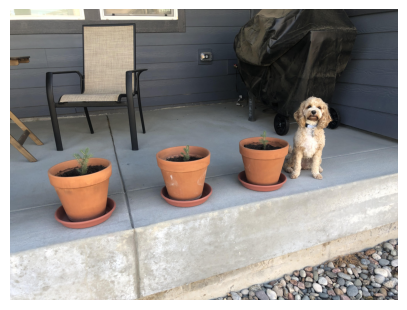

In [ ]:
filepath = tf.keras.utils.get_file(origin="https://i.imgur.com/gCNcJJI.jpg")
image = keras.utils.load_img(filepath)
image = np.array(image)

visualization.plot_image_gallery(
    [image],
    value_range=(0, 255),
    rows=1,
    cols=1,
    scale=5,
)
inference_resizing = keras_cv.layers.Resizing(
    640, 640, pad_to_aspect_ratio=True, bounding_box_format="xywh"
)
image_batch = inference_resizing([image])
class_ids = [
    "Aeroplane",
    "Bicycle",
    "Bird",
    "Boat",
    "Bottle",
    "Bus",
    "Car",
    "Cat",
    "Chair",
    "Cow",
    "Dining Table",
    "Dog",
    "Horse",
    "Motorbike",
    "Person",
    "Potted Plant",
    "Sheep",
    "Sofa",
    "Train",
    "Tvmonitor",
    "Total",
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))


1/1 [==============================] - 17s 17s/step


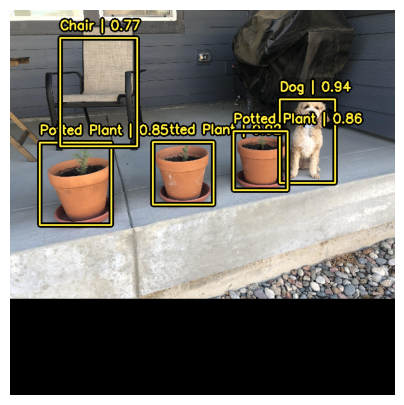

In [ ]:
y_pred = pretrained_model.predict(image_batch)

visualization.plot_bounding_box_gallery(
    image_batch,
    value_range=(0, 255),
    rows=1,
    cols=1,
    y_pred=y_pred,
    scale=5,
    font_scale=0.7,
    bounding_box_format="xywh",
    class_mapping=class_mapping,
)

1/1 [==============================] - 3s 3s/step


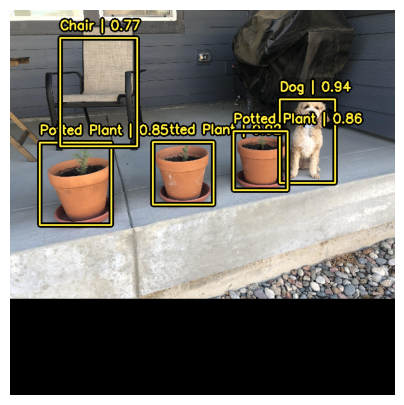

In [ ]:
prediction_decoder = keras_cv.layers.MultiClassNonMaxSuppression(
    bounding_box_format="xywh",
    from_logits=True,
    # Decrease the required threshold to make predictions get pruned out
    iou_threshold=0.2,
    # Tune confidence threshold for predictions to pass NMS
    confidence_threshold=0.7,
)
pretrained_model.prediction_decoder = prediction_decoder

y_pred = pretrained_model.predict(image_batch)
visualization.plot_bounding_box_gallery(
    image_batch,
    value_range=(0, 255),
    rows=1,
    cols=1,
    y_pred=y_pred,
    scale=5,
    font_scale=0.7,
    bounding_box_format="xywh",
    class_mapping=class_mapping,
)

In [ ]:
BATCH_SIZE=4
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )


def unpackage_raw_tfds_inputs(inputs, bounding_box_format):
    image = inputs["image"]
    boxes = keras_cv.bounding_box.convert_format(
        inputs["objects"]["bbox"],
        images=image,
        source="rel_yxyx",
        target=bounding_box_format,
    )
    bounding_boxes = {
        "classes": tf.cast(inputs["objects"]["label"], dtype=tf.float32),
        "boxes": tf.cast(boxes, dtype=tf.float32),
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}


def load_pascal_voc(split, dataset, bounding_box_format):
    ds = tfds.load(dataset, split=split, with_info=False, shuffle_files=True)
    ds = ds.map(
        lambda x: unpackage_raw_tfds_inputs(x, bounding_box_format=bounding_box_format),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    return ds


train_ds = load_pascal_voc(
    split="train", dataset="voc/2007", bounding_box_format="xyxy"
)
eval_ds = load_pascal_voc(split="test", dataset="voc/2007", bounding_box_format="xyxy")

train_ds = train_ds.shuffle(BATCH_SIZE * 4)

In [ ]:
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
eval_ds = eval_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)

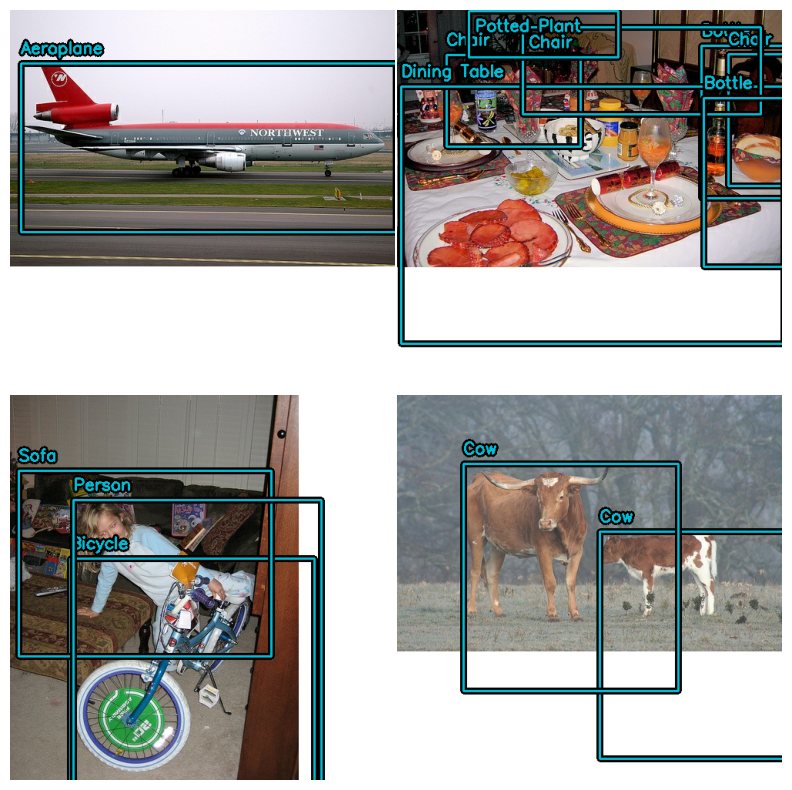

In [ ]:
visualize_dataset(
    train_ds, bounding_box_format="xywh", value_range=(0, 255), rows=2, cols=2
)

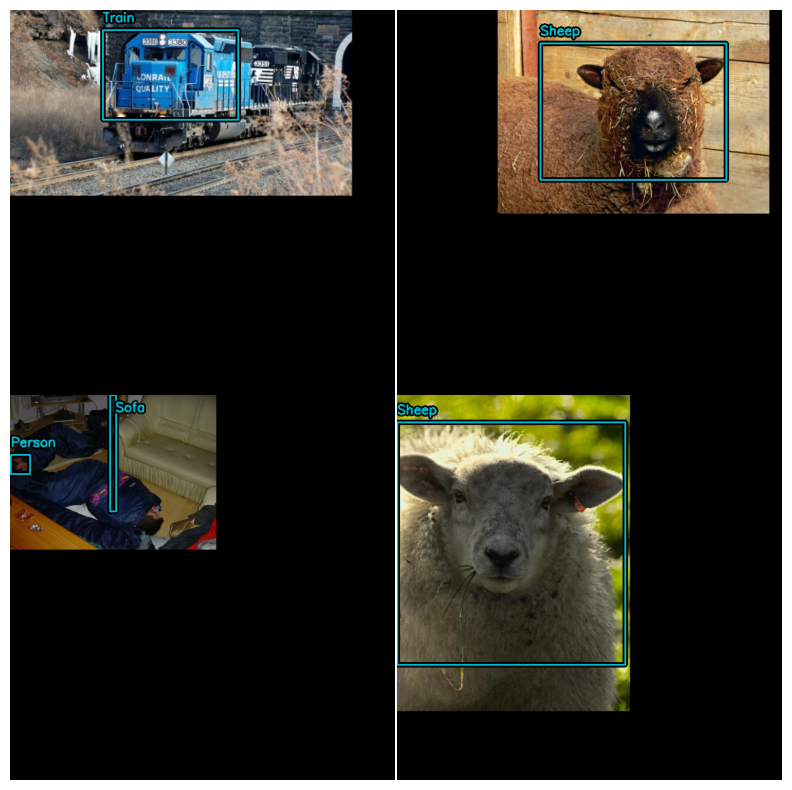

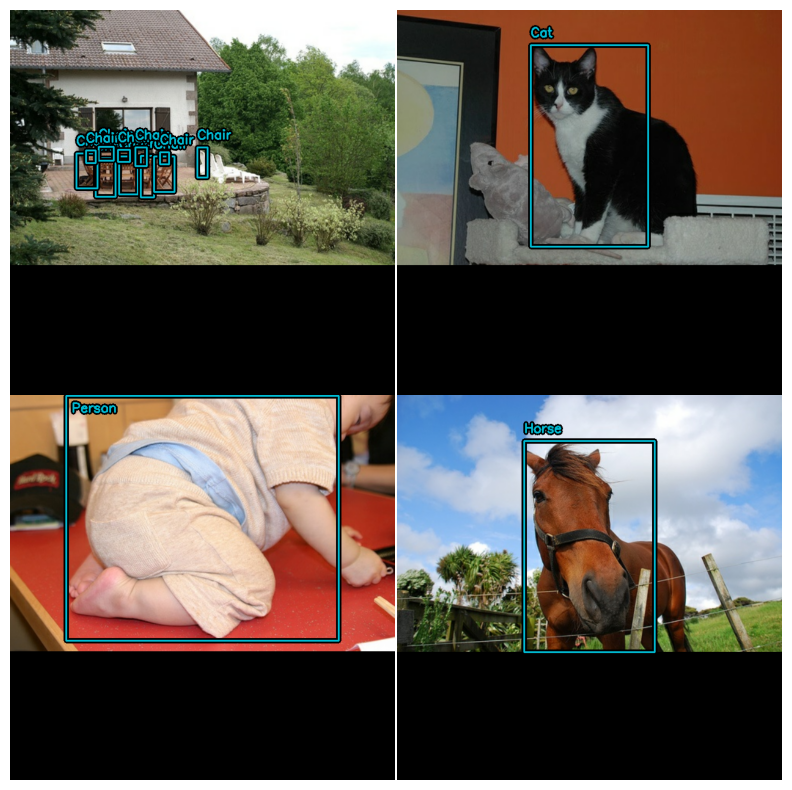

In [ ]:
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format="xyxy"
        ),
    ]
)

train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)
visualize_dataset(
    train_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

inference_resizing = keras_cv.layers.Resizing(
    640, 640, bounding_box_format="xyxy", pad_to_aspect_ratio=True
)
eval_ds = eval_ds.map(inference_resizing, num_parallel_calls=tf.data.AUTOTUNE)

visualize_dataset(
    eval_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

In [ ]:
def dict_to_tuple(inputs):
    return inputs["images"], bounding_box.to_dense(
        inputs["bounding_boxes"], max_boxes=32
    )


train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
eval_ds = eval_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
eval_ds = eval_ds.prefetch(tf.data.AUTOTUNE)

In [ ]:
# State: 0.20689
# Ratios: [0.434, 1.0, 2.302]
# Scales: [0.95, 1.217, 1.545]

In [ ]:
model = keras_cv.models.RetinaNet.from_preset(
    "resnet50_imagenet",
    anchor_generator = keras_cv.layers.AnchorGenerator(bounding_box_format='xyxy',scales =[0.95, 1.217, 1.545],aspect_ratios=[0.434, 1.0, 2.302] ,sizes = [32.0, 64.0, 128.0, 256.0, 512.0],
    strides = [2**i for i in range(3, 8)]),
    num_classes=len(class_mapping),
    bounding_box_format="xyxy",
)

base_lr = 0.005
# including a global_clipnorm is extremely important in object detection tasks
optimizer = tf.keras.optimizers.SGD(
    learning_rate=base_lr, momentum=0.9, global_clipnorm=10.0
)
model.compile(
    classification_loss="focal",
    box_loss="smoothl1",
    optimizer=optimizer,
    # We will use our custom callback to evaluate COCO metrics
    metrics=None,
)

class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format="xyxy",
            # passing 1e9 ensures we never evaluate until
            # `metrics.result(force=True)` is
            # called.
            evaluate_freq=1e9,
        )

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in tqdm.tqdm(self.data):
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)
        return logs

In [ ]:
model.fit(
    train_ds.take(20),
    validation_data=eval_ds.take(20),
    # Run for 10-35~ epochs to achieve good scores.
    epochs=10,
    callbacks=[EvaluateCOCOMetricsCallback(eval_ds.take(20))],
)

Epoch 1/10
20/20 [==============================] - ETA: 0s - loss: 1.9112 - box_loss: 0.7174 - classification_loss: 1.1938 - percent_boxes_matched_with_anchor: 0.9512

100%|██████████| 20/20 [00:08<00:00,  2.29it/s]

20/20 [==============================] - 76s 3s/step - loss: 1.9112 - box_loss: 0.7174 - classification_loss: 1.1938 - percent_boxes_matched_with_anchor: 0.9512 - val_loss: 1.8225 - val_box_loss: 0.7012 - val_classification_loss: 1.1213 - val_percent_boxes_matched_with_anchor: 0.9340 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00


Epoch 2/10
20/20 [==============================] - ETA: 0s - loss: 1.7067 - box_loss: 0.6812 - classification_loss: 1.0256 - percent_boxes_matched_with_anchor: 0.9492

100%|██████████| 20/20 [00:10<00:00,  1.90it/s]

20/20 [==============================] - 25s 1s/step - loss: 1.7067 - box_loss: 0.6812 - classification_loss: 1.0256 - percent_boxes_matched_with_anchor: 0.9492 - val_loss: 1.7234 - val_box_loss: 0.6881 - val_classification_loss: 1.0352 - val_percent_boxes_matched_with_anchor: 0.9340 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00


Epoch 3/10
20/20 [==============================] - ETA: 0s - loss: 1.5673 - box_loss: 0.6618 - classification_loss: 0.9055 - percent_boxes_matched_with_anchor: 0.9496

100%|██████████| 20/20 [00:06<00:00,  3.13it/s]

20/20 [==============================] - 21s 1s/step - loss: 1.5673 - box_loss: 0.6618 - classification_loss: 0.9055 - percent_boxes_matched_with_anchor: 0.9496 - val_loss: 1.6820 - val_box_loss: 0.6867 - val_classification_loss: 0.9953 - val_percent_boxes_matched_with_anchor: 0.9340 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00


Epoch 4/10
20/20 [==============================] - ETA: 0s - loss: 1.5440 - box_loss: 0.6542 - classification_loss: 0.8898 - percent_boxes_matched_with_anchor: 0.9500

100%|██████████| 20/20 [00:05<00:00,  3.44it/s]

20/20 [==============================] - 21s 1s/step - loss: 1.5440 - box_loss: 0.6542 - classification_loss: 0.8898 - percent_boxes_matched_with_anchor: 0.9500 - val_loss: 1.6224 - val_box_loss: 0.6816 - val_classification_loss: 0.9408 - val_percent_boxes_matched_with_anchor: 0.9402 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00


Epoch 5/10
20/20 [==============================] - ETA: 0s - loss: 1.4385 - box_loss: 0.6136 - classification_loss: 0.8249 - percent_boxes_matched_with_anchor: 0.9496

100%|██████████| 20/20 [00:06<00:00,  3.18it/s]

20/20 [==============================] - 21s 1s/step - loss: 1.4385 - box_loss: 0.6136 - classification_loss: 0.8249 - percent_boxes_matched_with_anchor: 0.9496 - val_loss: 2.6070 - val_box_loss: 0.6735 - val_classification_loss: 1.9335 - val_percent_boxes_matched_with_anchor: 0.9324 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00


Epoch 6/10
20/20 [==============================] - ETA: 0s - loss: 1.4024 - box_loss: 0.6083 - classification_loss: 0.7941 - percent_boxes_matched_with_anchor: 0.9500

100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


20/20 [==============================] - 26s 1s/step - loss: 1.4024 - box_loss: 0.6083 - classification_loss: 0.7941 - percent_boxes_matched_with_anchor: 0.9500 - val_loss: 73.7328 - val_box_loss: 0.7015 - val_classification_loss: 73.0313 - val_percent_boxes_matched_with_anchor: 0.9336 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 7/10
20/20 [==============================] - ETA: 0s - loss: 1.4602 - box_loss: 0.5864 - classification_loss: 0.8738 - percent_boxes_matched_with_anchor: 0.9465

100%|██████████| 20/20 [00:06<00:00,  3.27it/s]


20/20 [==============================] - 21s 1s/step - loss: 1.4602 - box_loss: 0.5864 - classification_loss: 0.8738 - percent_boxes_matched_with_anchor: 0.9465 - val_loss: 11.6291 - val_box_loss: 0.6830 - val_classification_loss: 10.9461 - val_percent_boxes_matched_with_anchor: 0.9262 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 8/10
20/20 [==============================] - ETA: 0s - loss: 1.4240 - box_loss: 0.6255 - classification_loss: 0.7984 - percent_boxes_matched_with_anchor: 0.9430

100%|██████████| 20/20 [00:10<00:00,  1.90it/s]

20/20 [==============================] - 26s 1s/step - loss: 1.4240 - box_loss: 0.6255 - classification_loss: 0.7984 - percent_boxes_matched_with_anchor: 0.9430 - val_loss: 8.6163 - val_box_loss: 0.6691 - val_classification_loss: 7.9473 - val_percent_boxes_matched_with_anchor: 0.9340 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00


Epoch 9/10
20/20 [==============================] - ETA: 0s - loss: 1.2763 - box_loss: 0.5636 - classification_loss: 0.7126 - percent_boxes_matched_with_anchor: 0.9531

100%|██████████| 20/20 [00:05<00:00,  3.38it/s]

20/20 [==============================] - 21s 1s/step - loss: 1.2763 - box_loss: 0.5636 - classification_loss: 0.7126 - percent_boxes_matched_with_anchor: 0.9531 - val_loss: 1.5692 - val_box_loss: 0.6633 - val_classification_loss: 0.9059 - val_percent_boxes_matched_with_anchor: 0.9340 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00


Epoch 10/10
20/20 [==============================] - ETA: 0s - loss: 1.3466 - box_loss: 0.5944 - classification_loss: 0.7522 - percent_boxes_matched_with_anchor: 0.9488

100%|██████████| 20/20 [00:05<00:00,  3.40it/s]

20/20 [==============================] - 23s 1s/step - loss: 1.3466 - box_loss: 0.5944 - classification_loss: 0.7522 - percent_boxes_matched_with_anchor: 0.9488 - val_loss: 1.5132 - val_box_loss: 0.6318 - val_classification_loss: 0.8814 - val_percent_boxes_matched_with_anchor: 0.9340 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00


In [ ]:
visualization_ds = eval_ds.unbatch()
visualization_ds = visualization_ds.ragged_batch(16)
visualization_ds = visualization_ds.shuffle(8)

1/1 [==============================] - 3s 3s/step


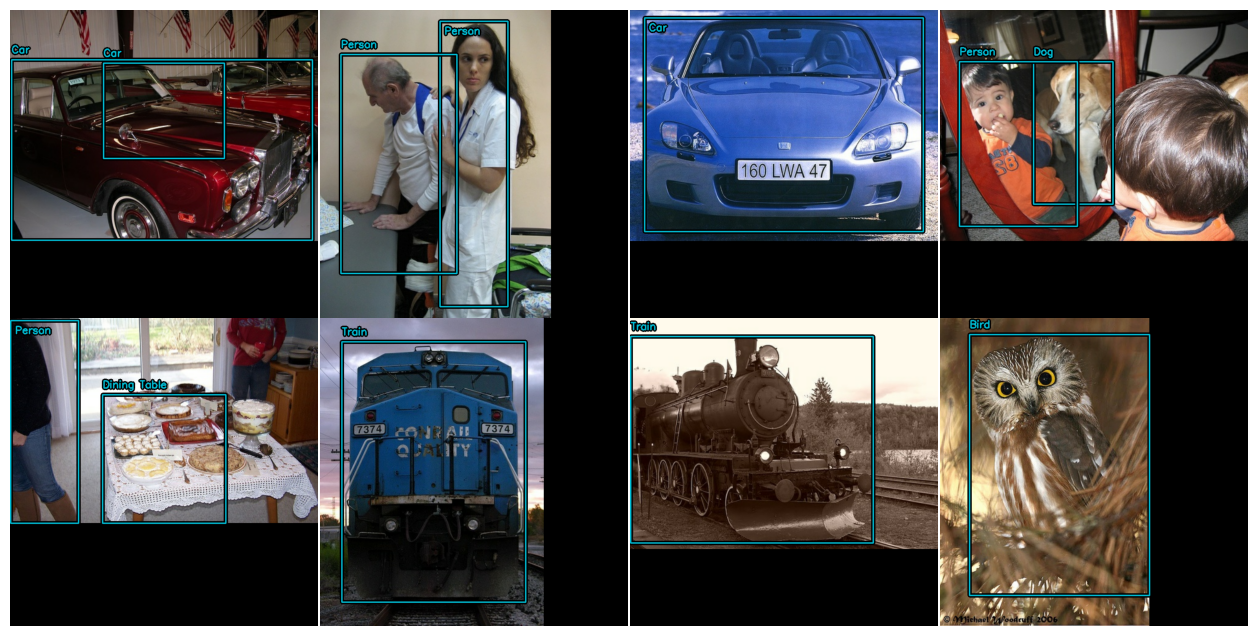

In [ ]:
def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)
    y_pred = bounding_box.to_ragged(y_pred)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=2,
        cols=4,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )

model.prediction_decoder = keras_cv.layers.MultiClassNonMaxSuppression(
    bounding_box_format="xyxy",
    from_logits=True,
    iou_threshold=0.5,
    confidence_threshold=0.75,
)

visualize_detections(model, dataset=visualization_ds, bounding_box_format="xyxy")